# Import & Set Variables

In [1]:
import pandas as pd
import numpy as np
import re

from sklearn.model_selection import train_test_split
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix, classification_report

from keras.utils import to_categorical


from keras.models import Sequential
from keras.layers import Dense, Dropout

import keras

from sklearn.metrics import precision_score, accuracy_score, f1_score, recall_score

from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, BaggingClassifier
from sklearn.svm import SVC

import matplotlib.pyplot as plt

%matplotlib inline

# dataset file name
fname = "cow.csv"

# normal values
NORMAL_TEMPERATURE = 37.8
NORMAL_PULSE = (30, 40)
NORMAL_RESPIRATORY_RATE = (8, 10)
NORMAL_NASOGASTRIC_REFLUX_PH = (3, 4)
NORMAL_PACKED_CELL_VOLUME = (30, 50)
NORMAL_TOTAL_PROTEIN = (6, 7.5)
NORMAL_ABDOMO_APPEARANCE = "clear"

---

# Load Data

In [2]:
df_cow = pd.read_csv(fname)
df_cow.columns

Index(['surgery', 'age', 'hospital_number', 'temperature', 'pulse',
       'respiratory_rate', 'temp_of_extremities', 'peripheral_pulse',
       'mucous_membrane', 'capillary_refill_time', 'pain', 'peristalsis',
       'abdominal_distention', 'nasogastric_tube', 'nasogastric_reflux',
       'nasogastric_reflux_ph', 'rectal_exam_feces', 'abdomen',
       'packed_cell_volume', 'total_protein', 'abdomo_appearance',
       'abdomo_protein', 'outcome Class', 'surgical_lesion', 'lesion'],
      dtype='object')

In [3]:
df_cow.head(5)

,surgery,age,hospital_number,temperature,pulse,respiratory_rate,temp_of_extremities,peripheral_pulse,mucous_membrane,capillary_refill_time,...,nasogastric_reflux_ph,rectal_exam_feces,abdomen,packed_cell_volume,total_protein,abdomo_appearance,abdomo_protein,outcome Class,surgical_lesion,lesion
0,no,adult,530101,38.5,66.0,28.0,cool,reduced,NaN,more_3_sec,...,NaN,decreased,distend_large,45.0,8.4,NaN,NaN,died,no,11300
1,yes,adult,534817,39.2,88.0,20.0,NaN,NaN,pale_cyanotic,less_3_sec,...,NaN,absent,other,50.0,85.0,cloudy,2.0,euthanized,no,2208
2,no,adult,530334,38.3,40.0,24.0,normal,normal,pale_pink,less_3_sec,...,NaN,normal,normal,33.0,6.7,NaN,NaN,lived,no,0
3,yes,young,5290409,39.1,164.0,84.0,cold,normal,dark_cyanotic,more_3_sec,...,5.0,decreased,NaN,48.0,7.2,serosanguious,5.3,died,yes,2208
4,no,adult,530255,37.3,104.0,35.0,NaN,NaN,dark_cyanotic,more_3_sec,...,NaN,NaN,NaN,74.0,7.4,NaN,NaN,died,no,4300


---

# Funtion

## visualization

In [4]:
def plot_loss_accuracy(history):
    print_score(history)
    
    fig = plt.figure(figsize=(12, 6))
    ax = fig.add_subplot(1, 2, 1)
    ax.plot(history.history["loss"],'r-x', label="Train Loss")
    ax.plot(history.history["val_loss"],'b-x', label="Validation Loss")
    ax.legend()
    ax.set_title('cross_entropy loss')
    ax.grid(True)


    ax = fig.add_subplot(1, 2, 2)
    ax.plot(history.history["accuracy"],'r-x', label="Train Accuracy")
    ax.plot(history.history["val_accuracy"],'b-x', label="Validation Accuracy")
    ax.legend()
    ax.set_title('accuracy')
    ax.grid(True)

def print_score(history):
    print("lastes accuracy and loss")
    print("train_loss : {:.4f}, val_loss : {:.4f}\ntrain_acc : {:.4f}, val_acc : {:.4f}".format(history.history['loss'][-1],
                                                                                               history.history['val_loss'][-1],
                                                                                               history.history['accuracy'][-1],
                                                                                               history.history['val_accuracy'][-1]))

In [5]:
def create_confusion_matrix(model,x_val,y_val,label_names):
    y_probs = model.predict(x_val)
    if(y_probs[0].size > 1):
        y_preds = y_probs.argmax(axis=1)
        y_val = y_val.argmax(axis=1)
    else:
        y_preds = y_probs
    
    #Confusion matrix
    cm= confusion_matrix(y_val,y_preds)

    #Plot
    disp=ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=label_names)
    fig, ax = plt.subplots(figsize=(5,5))
    disp.plot(ax=ax,xticks_rotation=45)

## preprocessing

In [6]:
def extract_lesion_column(lesion):
    site, type_l, subtype, code = 'None', 'None', 'None', 'None'
    if lesion != 0:
        types = re.findall('^([1-9]|11|00)([1-4])([0-2])([1-9]|10|0)',str(lesion))
        if types:
            site, type_l, subtype, code = types[0]
    return pd.Series({'site': site, 'type': type_l, 'subtype': subtype, 'code': code}, dtype='category')


# Preprocess Data

In [7]:
n_name = ["lived","died","euthanized"]

In [8]:
df_cow.loc[:, ['site', 'type', 'subtype', 'code']] = df_cow.lesion.apply(extract_lesion_column).astype('category')

In [9]:
df_cow.head()

,surgery,age,hospital_number,temperature,pulse,respiratory_rate,temp_of_extremities,peripheral_pulse,mucous_membrane,capillary_refill_time,...,total_protein,abdomo_appearance,abdomo_protein,outcome Class,surgical_lesion,lesion,site,type,subtype,code
0,no,adult,530101,38.5,66.0,28.0,cool,reduced,NaN,more_3_sec,...,8.4,NaN,NaN,died,no,11300,11,3,0,0
1,yes,adult,534817,39.2,88.0,20.0,NaN,NaN,pale_cyanotic,less_3_sec,...,85.0,cloudy,2.0,euthanized,no,2208,2,2,0,8
2,no,adult,530334,38.3,40.0,24.0,normal,normal,pale_pink,less_3_sec,...,6.7,NaN,NaN,lived,no,0,None,None,None,None
3,yes,young,5290409,39.1,164.0,84.0,cold,normal,dark_cyanotic,more_3_sec,...,7.2,serosanguious,5.3,died,yes,2208,2,2,0,8
4,no,adult,530255,37.3,104.0,35.0,NaN,NaN,dark_cyanotic,more_3_sec,...,7.4,NaN,NaN,died,no,4300,4,3,0,0


In [10]:
#drop column ที่ไม่จำเป็น
if "outcome Class" in df_cow.columns:
    y = df_cow['outcome Class']
    df_cow.drop(columns=["outcome Class"], inplace=True)
if "lesion" in df_cow.columns:
    df_cow.drop(columns=['hospital_number',"lesion"], inplace=True)
df_cow.head()

,surgery,age,temperature,pulse,respiratory_rate,temp_of_extremities,peripheral_pulse,mucous_membrane,capillary_refill_time,pain,...,abdomen,packed_cell_volume,total_protein,abdomo_appearance,abdomo_protein,surgical_lesion,site,type,subtype,code
0,no,adult,38.5,66.0,28.0,cool,reduced,NaN,more_3_sec,extreme_pain,...,distend_large,45.0,8.4,NaN,NaN,no,11,3,0,0
1,yes,adult,39.2,88.0,20.0,NaN,NaN,pale_cyanotic,less_3_sec,mild_pain,...,other,50.0,85.0,cloudy,2.0,no,2,2,0,8
2,no,adult,38.3,40.0,24.0,normal,normal,pale_pink,less_3_sec,mild_pain,...,normal,33.0,6.7,NaN,NaN,no,None,None,None,None
3,yes,young,39.1,164.0,84.0,cold,normal,dark_cyanotic,more_3_sec,depressed,...,NaN,48.0,7.2,serosanguious,5.3,yes,2,2,0,8
4,no,adult,37.3,104.0,35.0,NaN,NaN,dark_cyanotic,more_3_sec,NaN,...,NaN,74.0,7.4,NaN,NaN,no,4,3,0,0


In [11]:
numerical = list(df_cow._get_numeric_data().columns)
categorical = list(set(df_cow.columns) - set(numerical))

In [12]:
df_cow.fillna(df_cow.mean(numeric_only=True), inplace=True)
df_cow.mean(numeric_only=True)

temperature              38.168619
pulse                    72.000000
respiratory_rate         30.460581
nasogastric_reflux_ph     4.707547
packed_cell_volume       46.307407
total_protein            24.274436
abdomo_protein            3.039604
dtype: float64

In [13]:
df_cow_numerical = df_cow[numerical].copy()
df_cow_numerical.head()

,temperature,pulse,respiratory_rate,nasogastric_reflux_ph,packed_cell_volume,total_protein,abdomo_protein
0,38.5,66.0,28.0,4.707547,45.0,8.4,3.039604
1,39.2,88.0,20.0,4.707547,50.0,85.0,2.000000
2,38.3,40.0,24.0,4.707547,33.0,6.7,3.039604
3,39.1,164.0,84.0,5.000000,48.0,7.2,5.300000
4,37.3,104.0,35.0,4.707547,74.0,7.4,3.039604


In [14]:
df_cow_categorical = pd.DataFrame()

for c in categorical:
    encoded = pd.get_dummies(df_cow[c], dummy_na=True, prefix=c)
    df_cow_categorical = pd.concat([df_cow_categorical, encoded], axis=1)

df_cow_categorical.head()

,mucous_membrane_bright_pink,mucous_membrane_bright_red,mucous_membrane_dark_cyanotic,mucous_membrane_normal_pink,mucous_membrane_pale_cyanotic,mucous_membrane_pale_pink,mucous_membrane_nan,site_1,site_11,site_2,...,code_nan,abdomen_distend_large,abdomen_distend_small,abdomen_firm,abdomen_normal,abdomen_other,abdomen_nan,age_adult,age_young,age_nan
0,0,0,0,0,0,0,1,0,1,0,...,0,1,0,0,0,0,0,1,0,0
1,0,0,0,0,1,0,0,0,0,1,...,0,0,0,0,0,1,0,1,0,0
2,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,1,0,0,1,0,0
3,0,0,1,0,0,0,0,0,0,1,...,0,0,0,0,0,0,1,0,1,0
4,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,1,0,0


In [15]:
df_cow_data = pd.concat([df_cow_numerical,df_cow_categorical],axis=1)
df_cow_data.head()

,temperature,pulse,respiratory_rate,nasogastric_reflux_ph,packed_cell_volume,total_protein,abdomo_protein,mucous_membrane_bright_pink,mucous_membrane_bright_red,mucous_membrane_dark_cyanotic,...,code_nan,abdomen_distend_large,abdomen_distend_small,abdomen_firm,abdomen_normal,abdomen_other,abdomen_nan,age_adult,age_young,age_nan
0,38.5,66.0,28.0,4.707547,45.0,8.4,3.039604,0,0,0,...,0,1,0,0,0,0,0,1,0,0
1,39.2,88.0,20.0,4.707547,50.0,85.0,2.000000,0,0,0,...,0,0,0,0,0,1,0,1,0,0
2,38.3,40.0,24.0,4.707547,33.0,6.7,3.039604,0,0,0,...,0,0,0,0,1,0,0,1,0,0
3,39.1,164.0,84.0,5.000000,48.0,7.2,5.300000,0,0,1,...,0,0,0,0,0,0,1,0,1,0
4,37.3,104.0,35.0,4.707547,74.0,7.4,3.039604,0,0,1,...,0,0,0,0,0,0,1,1,0,0


In [16]:
y = y.map({"lived": 0, "died": 1, "euthanized": 2})
y.head()

0    1
1    2
2    0
3    1
4    1
Name: outcome Class, dtype: int64

In [17]:
X = df_cow_data.values

In [18]:
X.shape, y.shape

((299, 111), (299,))

In [19]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, stratify=y,random_state=1234)

In [20]:
print(np.unique(y_train,return_counts=True))

(array([0, 1, 2], dtype=int64), array([142,  62,  35], dtype=int64))


In [21]:
print(np.unique(y_test,return_counts=True))

(array([0, 1, 2], dtype=int64), array([36, 15,  9], dtype=int64))


In [22]:
from imblearn.over_sampling import SMOTE
smote = SMOTE(random_state=1234)
X_train, y_train = smote.fit_resample(X_train, y_train)
print(np.unique(y_train,return_counts=True))

(array([0, 1, 2], dtype=int64), array([142, 142, 142], dtype=int64))


In [23]:
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size =81, stratify=y_train,random_state=1234)

In [24]:
print(np.unique(y_train,return_counts=True))

(array([0, 1, 2], dtype=int64), array([115, 115, 115], dtype=int64))


In [25]:
print(np.unique(y_val,return_counts=True))

(array([0, 1, 2], dtype=int64), array([27, 27, 27], dtype=int64))


In [26]:
y_train = keras.utils.to_categorical(y_train,3)
y_val = keras.utils.to_categorical(y_val,3)
# y_test = keras.utils.to_categorical(y_test,3)

---

# Training Models

## Non-ensemble

### Neural Network

In [27]:
nn_model = Sequential([
    Dense(64, activation="relu", input_shape=X_train[0].shape),
    Dense(64, activation="relu"),
    Dropout(0.5),
    
    Dense(128, activation="relu"),
    Dense(128, activation="relu"),
    Dropout(0.8),
    
    Dense(3, activation="softmax"),
])

nn_model.compile(optimizer='adam',
                 loss="categorical_crossentropy", 
                 metrics=[
                     "accuracy",
                     keras.metrics.Precision()
                     ])

nn_history = nn_model.fit(X_train, y_train, epochs=100
            ,validation_data=(X_val, y_val))

Epoch 1/100
11/11 [==============================] - 2s 48ms/step - loss: 5.9019 - accuracy: 0.3246 - precision: 0.3224 - val_loss: 1.5247 - val_accuracy: 0.3333 - val_precision: 0.3333
Epoch 2/100
11/11 [==============================] - 0s 15ms/step - loss: 2.8388 - accuracy: 0.3826 - precision: 0.3825 - val_loss: 0.8811 - val_accuracy: 0.5802 - val_precision: 0.7436
Epoch 3/100
11/11 [==============================] - 0s 19ms/step - loss: 1.8564 - accuracy: 0.3884 - precision: 0.3994 - val_loss: 0.8902 - val_accuracy: 0.6173 - val_precision: 0.8438
Epoch 4/100
11/11 [==============================] - 0s 14ms/step - loss: 1.4981 - accuracy: 0.4145 - precision: 0.4460 - val_loss: 0.9324 - val_accuracy: 0.6173 - val_precision: 0.7500
Epoch 5/100
11/11 [==============================] - 0s 23ms/step - loss: 1.3414 - accuracy: 0.3797 - precision: 0.3959 - val_loss: 0.9443 - val_accuracy: 0.5185 - val_precision: 0.7500
Epoch 6/100
11/11 [==============================] - 0s 21ms/step - lo

Epoch 45/100
11/11 [==============================] - 0s 31ms/step - loss: 0.6296 - accuracy: 0.7478 - precision: 0.7944 - val_loss: 0.5396 - val_accuracy: 0.7901 - val_precision: 0.8261
Epoch 46/100
11/11 [==============================] - 0s 24ms/step - loss: 0.6260 - accuracy: 0.7565 - precision: 0.8007 - val_loss: 0.5730 - val_accuracy: 0.7654 - val_precision: 0.7778
Epoch 47/100
11/11 [==============================] - 0s 28ms/step - loss: 0.6739 - accuracy: 0.7507 - precision: 0.7978 - val_loss: 0.5632 - val_accuracy: 0.7778 - val_precision: 0.8116
Epoch 48/100
11/11 [==============================] - 0s 19ms/step - loss: 0.6488 - accuracy: 0.7594 - precision: 0.8043 - val_loss: 0.5116 - val_accuracy: 0.7901 - val_precision: 0.8243
Epoch 49/100
11/11 [==============================] - 0s 13ms/step - loss: 0.6563 - accuracy: 0.7507 - precision: 0.8104 - val_loss: 0.5601 - val_accuracy: 0.8272 - val_precision: 0.8261
Epoch 50/100
11/11 [==============================] - 0s 13ms/ste

Epoch 89/100
11/11 [==============================] - 0s 14ms/step - loss: 0.2910 - accuracy: 0.8870 - precision: 0.9167 - val_loss: 0.3591 - val_accuracy: 0.9259 - val_precision: 0.9259
Epoch 90/100
11/11 [==============================] - 0s 14ms/step - loss: 0.2610 - accuracy: 0.9014 - precision: 0.9224 - val_loss: 0.3664 - val_accuracy: 0.9136 - val_precision: 0.9136
Epoch 91/100
11/11 [==============================] - 0s 13ms/step - loss: 0.2562 - accuracy: 0.9014 - precision: 0.9266 - val_loss: 0.4003 - val_accuracy: 0.9012 - val_precision: 0.9012
Epoch 92/100
11/11 [==============================] - 0s 16ms/step - loss: 0.3092 - accuracy: 0.8841 - precision: 0.8969 - val_loss: 0.3349 - val_accuracy: 0.9136 - val_precision: 0.9241
Epoch 93/100
11/11 [==============================] - 0s 22ms/step - loss: 0.3040 - accuracy: 0.8841 - precision: 0.9167 - val_loss: 0.3747 - val_accuracy: 0.9012 - val_precision: 0.9012
Epoch 94/100
11/11 [==============================] - 0s 20ms/ste

In [28]:
y_pred_nn = np.argmax(nn_model.predict(X_test),axis=1)
nn_model_acc = accuracy_score(y_test, y_pred_nn)
nn_model_prec = precision_score(y_test, y_pred_nn, average=None)
nn_model_f1 = f1_score(y_test, y_pred_nn, average=None)
nn_model_recall = recall_score(y_test, y_pred_nn, average=None)

2/2 [==============================] - 0s 5ms/step


lastes accuracy and loss
train_loss : 0.2097, val_loss : 0.4581
train_acc : 0.9304, val_acc : 0.9012


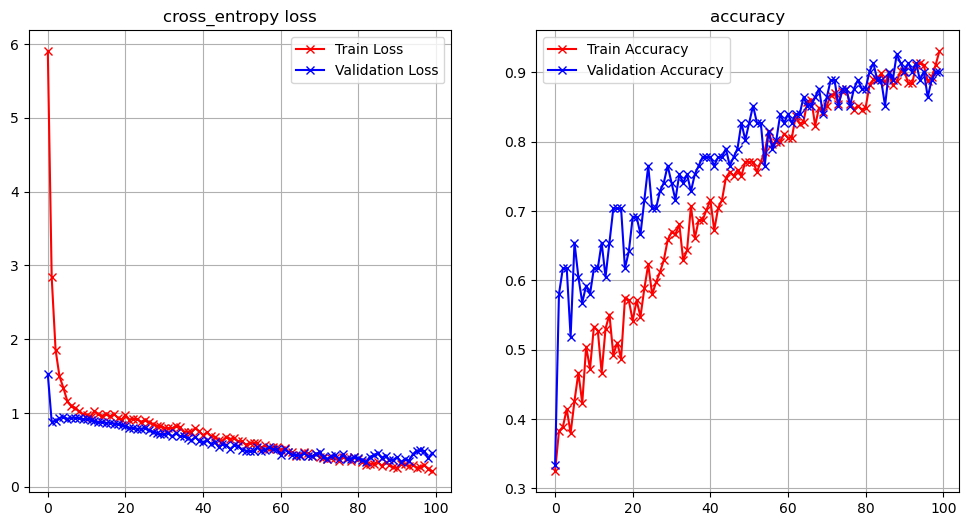

In [29]:
plot_loss_accuracy(nn_history)

### KNN

In [30]:
knn_model = KNeighborsClassifier(n_neighbors=5)
knn_model.fit(X_train, y_train)

KNeighborsClassifier()

In [31]:
y_pred_knn = np.argmax(knn_model.predict(X_test), axis=1)
knn_model_acc = accuracy_score(y_test, y_pred_knn)
knn_model_prec = precision_score(y_test, y_pred_knn, average=None)
knn_model_f1 = f1_score(y_test, y_pred_knn, average=None)
knn_model_recall = recall_score(y_test, y_pred_knn, average=None)

C:\Users\tong_\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)


## Ensemble

### Random Forest

In [32]:
rfc_model = RandomForestClassifier(n_estimators=1000)
rfc_model.fit(X_train, y_train)


RandomForestClassifier(n_estimators=1000)

In [33]:
y_pred_rf = np.argmax(rfc_model.predict(X_test), axis=1)
rfc_model_acc = accuracy_score(y_test, y_pred_rf)
rfc_model_prec = precision_score(y_test, y_pred_rf, average=None)
rfc_model_f1 = f1_score(y_test, y_pred_rf, average=None)
rfc_model_recall = recall_score(y_test, y_pred_rf, average=None)

### AdaBoost

In [34]:
ada_model = AdaBoostClassifier(DecisionTreeClassifier(), n_estimators=1000)
ada_model.fit(X_train, np.argmax(y_train, axis=1))

AdaBoostClassifier(base_estimator=DecisionTreeClassifier(), n_estimators=1000)

In [35]:
y_pred_ada =  ada_model.predict(X_test)
ada_model_acc = accuracy_score(y_test, y_pred_ada)
ada_model_prec = precision_score(y_test, y_pred_ada, average=None)
ada_model_f1 = f1_score(y_test, y_pred_ada, average=None)
ada_model_recall = recall_score(y_test, y_pred_ada, average=None)

### Bagging

In [36]:
bag_model = BaggingClassifier(SVC(), n_estimators=1000)
bag_model.fit(X_train,  np.argmax(y_train,axis=1))

BaggingClassifier(base_estimator=SVC(), n_estimators=1000)

In [37]:
y_pred_bag =  bag_model.predict(X_test)
bag_model_acc = accuracy_score(y_test, y_pred_bag)
bag_model_prec = precision_score(y_test, y_pred_bag, average=None)
bag_model_f1 = f1_score(y_test, y_pred_bag, average=None)
bag_model_recall = recall_score(y_test, y_pred_bag, average=None)

---

# Visualisation

## Confusion Matrix

2/2 [==============================] - 0s 5ms/step


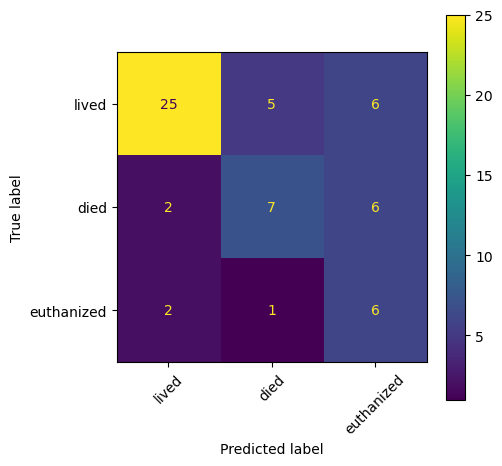

In [38]:
create_confusion_matrix(nn_model,X_test,keras.utils.to_categorical(y_test,3),n_name)

C:\Users\tong_\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)


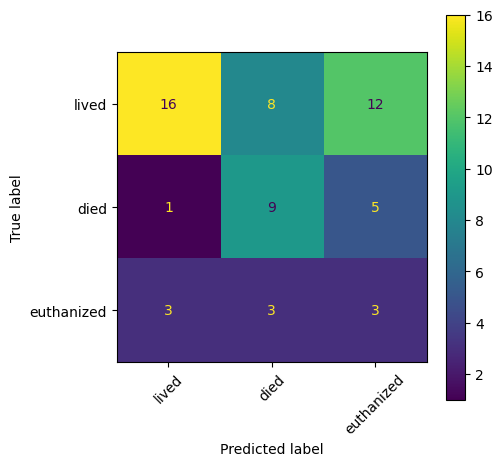

In [39]:
create_confusion_matrix(knn_model,X_test,keras.utils.to_categorical(y_test,3),n_name)

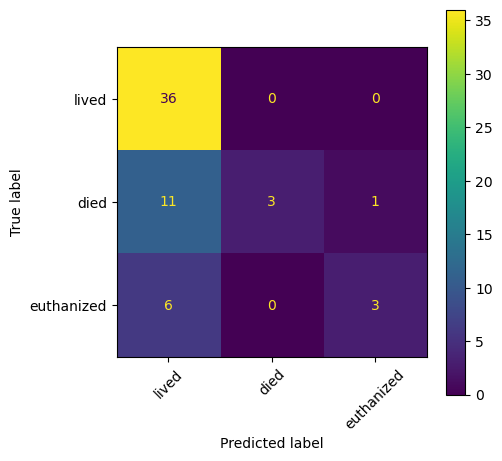

In [40]:
create_confusion_matrix(rfc_model,X_test,keras.utils.to_categorical(y_test,3),n_name)

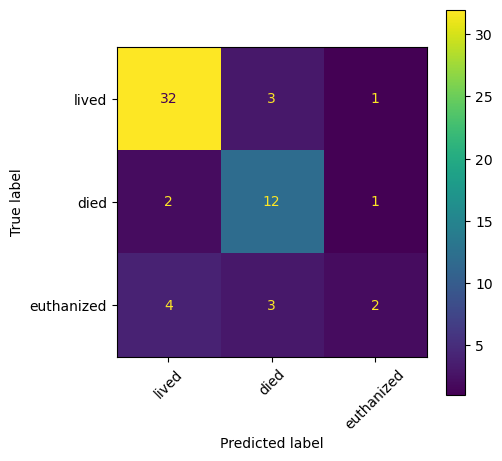

In [41]:
create_confusion_matrix(ada_model,X_test,y_test,n_name)

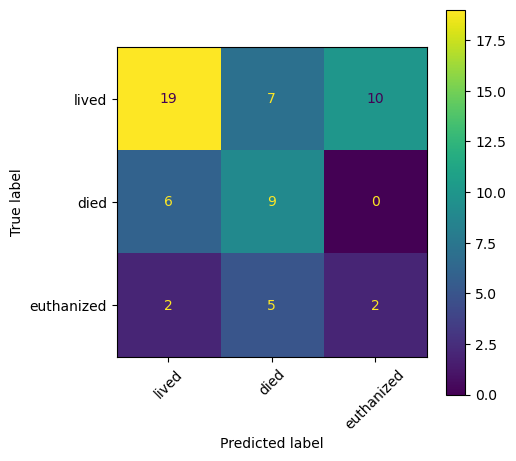

In [42]:
create_confusion_matrix(bag_model,X_test,y_test,n_name)

## Accuracy

Model : Accuracy


KeyError: '-10'

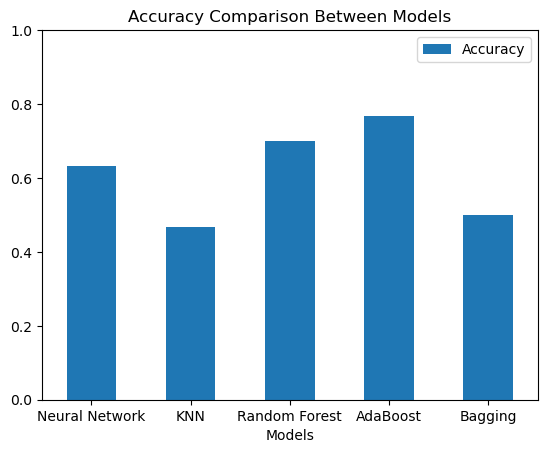

In [71]:
df = pd.DataFrame({'Models':['Neural Network', 'KNN', 'Random Forest', "AdaBoost", "Bagging"], 'Accuracy':[nn_model_acc, knn_model_acc, rfc_model_acc, ada_model_acc, bag_model_acc]})
ax = df.plot.bar(x='Models', y='Accuracy', rot=0, ylim=(0, 1), title="Accuracy Comparison Between Models")

print("Model : Accuracy")
for i in df.values:
    print("{-10:s} : {:.2f}".format(i[0],i[1]))

## Precision

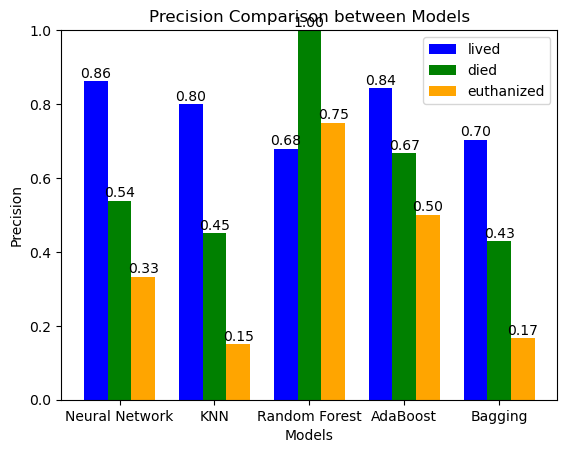

In [48]:
precs = [nn_model_prec, knn_model_prec, rfc_model_prec, ada_model_prec, bag_model_prec]
ind = np.arange(len(precs))
width = 0.25

class_0 = [nn_model_prec[0], knn_model_prec[0], rfc_model_prec[0], ada_model_prec[0], bag_model_prec[0]]
bar1 = plt.bar(ind, class_0, width, color = 'blue')
  
class_1 = [nn_model_prec[1], knn_model_prec[1], rfc_model_prec[1], ada_model_prec[1], bag_model_prec[1]]
bar2 = plt.bar(ind+width, class_1, width, color='g')
  
class_2 = [nn_model_prec[2], knn_model_prec[2], rfc_model_prec[2], ada_model_prec[2], bag_model_prec[2]]
bar3 = plt.bar(ind+width*2, class_2, width, color = 'orange')
  
plt.xlabel("Models")
plt.ylabel('Precision')
plt.title("Precision Comparison between Models")
plt.ylim((0, 1))

for index, value in enumerate(precs):
    for i,v in enumerate(value):
        plt.text(x=index + (0.25*i), y=v+0.01, s="{:.2f}".format(v), ha='center')

plt.xticks(ind+width,['Neural Network', 'KNN', 'Random Forest', "AdaBoost", "Bagging"])
plt.legend( (bar1, bar2, bar3), ("lived", "died", "euthanized") )
plt.show()

## F1

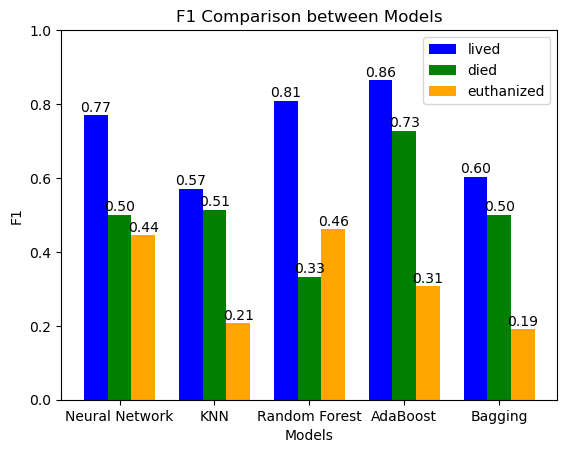

In [49]:
f1 = [nn_model_f1, knn_model_f1, rfc_model_f1, ada_model_f1, bag_model_f1]
ind = np.arange(len(f1))
width = 0.25

class_0 = [nn_model_f1[0], knn_model_f1[0], rfc_model_f1[0], ada_model_f1[0], bag_model_f1[0]]
bar1 = plt.bar(ind, class_0, width, color = 'blue')
  
class_1 = [nn_model_f1[1], knn_model_f1[1], rfc_model_f1[1], ada_model_f1[1], bag_model_f1[1]]
bar2 = plt.bar(ind+width, class_1, width, color='g')
  
class_2 = [nn_model_f1[2], knn_model_f1[2], rfc_model_f1[2], ada_model_f1[2], bag_model_f1[2]]
bar3 = plt.bar(ind+width*2, class_2, width, color = 'orange')
  
plt.xlabel("Models")
plt.ylabel('F1')
plt.title("F1 Comparison between Models")
plt.ylim((0, 1))

for index, value in enumerate(f1):
    for i,v in enumerate(value):
        plt.text(x=index + (0.25*i), y=v+0.01, s="{:.2f}".format(v), ha='center')

plt.xticks(ind+width,['Neural Network', 'KNN', 'Random Forest', "AdaBoost", "Bagging"])
plt.legend( (bar1, bar2, bar3), ("lived", "died", "euthanized") )
plt.show()

## Recall

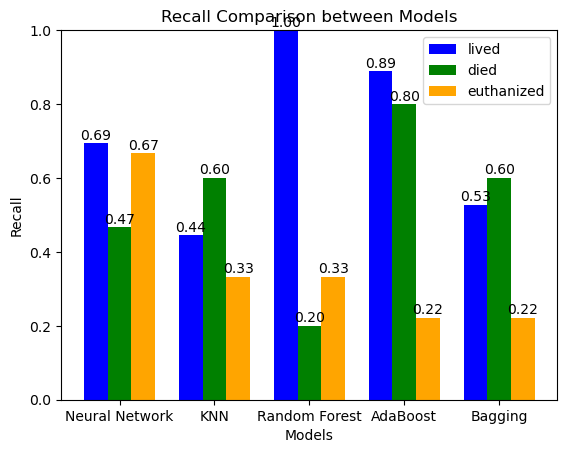

In [50]:
recall = [nn_model_recall, knn_model_recall, rfc_model_recall, ada_model_recall, bag_model_recall]
ind = np.arange(len(recall))
width = 0.25

class_0 = [nn_model_recall[0], knn_model_recall[0], rfc_model_recall[0], ada_model_recall[0], bag_model_recall[0]]
bar1 = plt.bar(ind, class_0, width, color = 'blue')
  
class_1 = [nn_model_recall[1], knn_model_recall[1], rfc_model_recall[1], ada_model_recall[1], bag_model_recall[1]]
bar2 = plt.bar(ind+width, class_1, width, color='g')
  
class_2 = [nn_model_recall[2], knn_model_recall[2], rfc_model_recall[2], ada_model_recall[2], bag_model_recall[2]]
bar3 = plt.bar(ind+width*2, class_2, width, color = 'orange')
  
plt.xlabel("Models")
plt.ylabel('Recall')
plt.title("Recall Comparison between Models")
plt.ylim((0, 1))
  
for index, value in enumerate(recall):
    for i,v in enumerate(value):
        plt.text(x=index + (0.25*i), y=v+0.01, s="{:.2f}".format(v), ha='center')
    
plt.xticks(ind+width,['Neural Network', 'KNN', 'Random Forest', "AdaBoost", "Bagging"])
plt.legend( (bar1, bar2, bar3), ("lived", "died", "euthanized") )
plt.show()

---